<img src='./figures/CEA_logo_nouveau.svg' style='position:absolute; top:0; right:0;' width='100px' height='' alt='' />

<center>Multi-fidelity Gaussian process regression </center>
<center><i>Practical Session</i> part I </center>

# Autoregressive model: AR(1) multi-fidelity

&nbsp;

<!--<img src="./figures/Catalan.png" alt="Roots" style="width: 350px;"/>

&nbsp;
<center><i>The <a href="https://en.wikipedia.org/wiki/Catalan_number"><b>Catalan numbers</b></a> (see the last exercise) arise when one wants to enumerate <i>binary trees</i>.</i></center>-->

## Table of contents

- [Simple-Fidelity Gaussian process regresion](#SFGPR)
- [Multi-Fidelity in 1 dimension](#Illustration)
- [Double pendulum, the illustration](#Example)

In [1]:
library(MuFiCokriging)
library(pracma)
require(DiceDesign)

Le chargement a nécessité le package : DiceKriging

Le chargement a nécessité le package : DiceDesign



<a id="SFGPR"></a>
## Simple-Fidelity Gaussian process regression

Simple fidelity toy function

In [3]:
f=function(x){return=x*sin(x)}

Definition of the test set

In [4]:
N=10
x=sort(runif(N)*10)
y=f(x)

Model construction

In [5]:
# Change parameters
theta = 1# correlation length
sigma = 2 # standard deviation
trend = c(0,0)#c(-1,2) # trend
cov.type="matern3_2"#matern5_2"
model = km(~x,design=data.frame(x=x),response=data.frame(y=y), covtype=cov.type, coef.trend=trend, coef.cov=theta,coef.var=sigma^2)

prediction

In [6]:
# prédiction
xD=seq(0,10,length=1000)
p = predict(model, data.frame(x=xD), "UK")

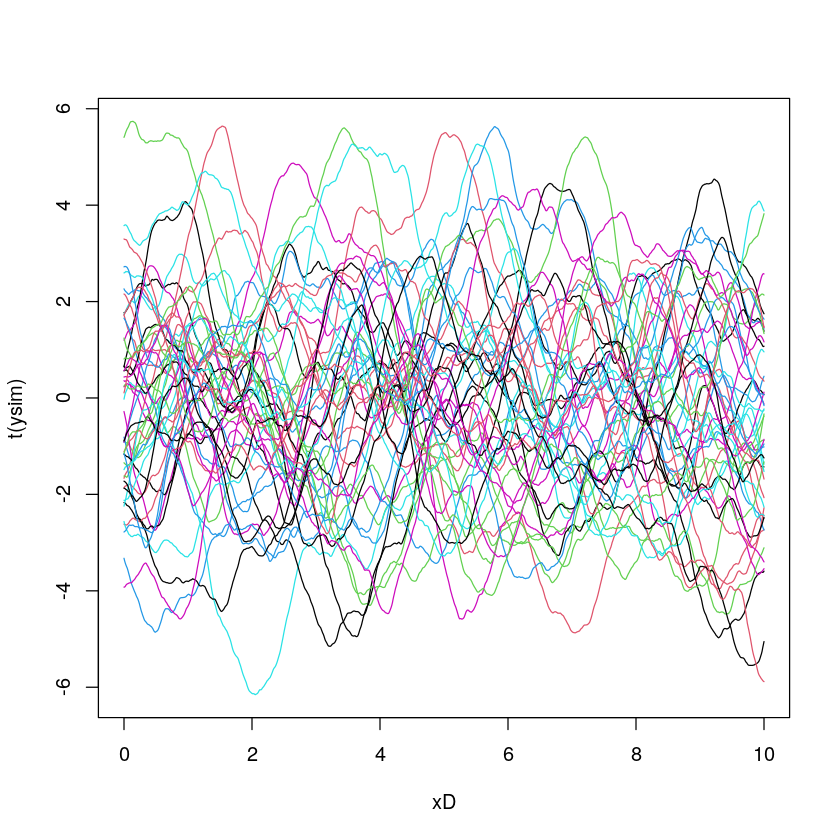

In [7]:
Nsim=50
ysim = simulate(model,nsim=Nsim,newdata=xD,checkNames=F,cond=FALSE)
matplot(xD,t(ysim),type='l',lty=1)

With conditioning

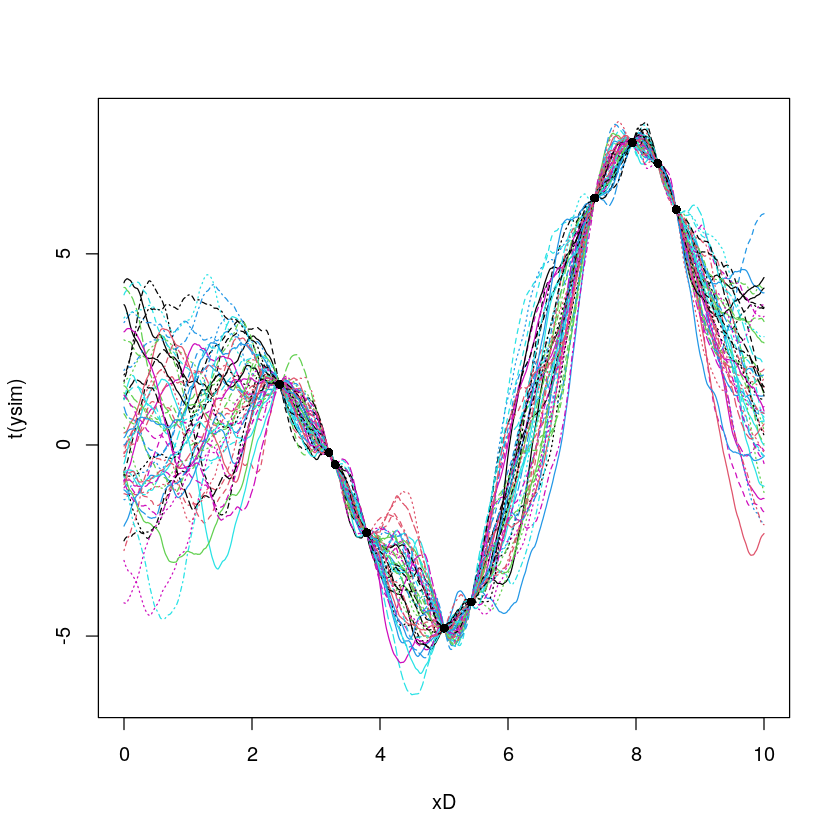

In [7]:
ysim = simulate(model,nsim=Nsim,newdata=xD,checkNames=F,cond=TRUE)
matplot(xD,t(ysim),type='l')
points(x,y,pch=16,cex=1)

In [8]:
# cross-validation: Leave one out
LOO=leaveOneOut.km(model, type="UK", trend.reestim=FALSE)

err.VC = mean((LOO$mean-y)^2/LOO$sd^2)
print(err.VC)
Q2 = 1-mean((LOO$mean-y)^2)/var(y)
print(Q2)

[1] 0.3002432
[1] 0.9818417


Fit the model without trend

In [9]:
fittedmodel=km(design=data.frame(x=x),response=data.frame(y=y))
fittedp = predict(fittedmodel, data.frame(x=xD), "UK")


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  12.3996 
  - best initial criterion value(s) :  -13.78532 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       13.785  |proj g|=      0.39921
At iterate     1  f =       13.655  |proj g|=       0.23375
At iterate     2  f =       13.618  |proj g|=      0.015302
At iterate     3  f =       13.618  |proj g|=     0.0048708
At iterate     4  f =       13.618  |proj g|=     6.982e-05
At iterate     5  f =       13.618  |proj g|=    3.1256e-07

iterations 5
function evaluations 7
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 3.1256e-07
final function 

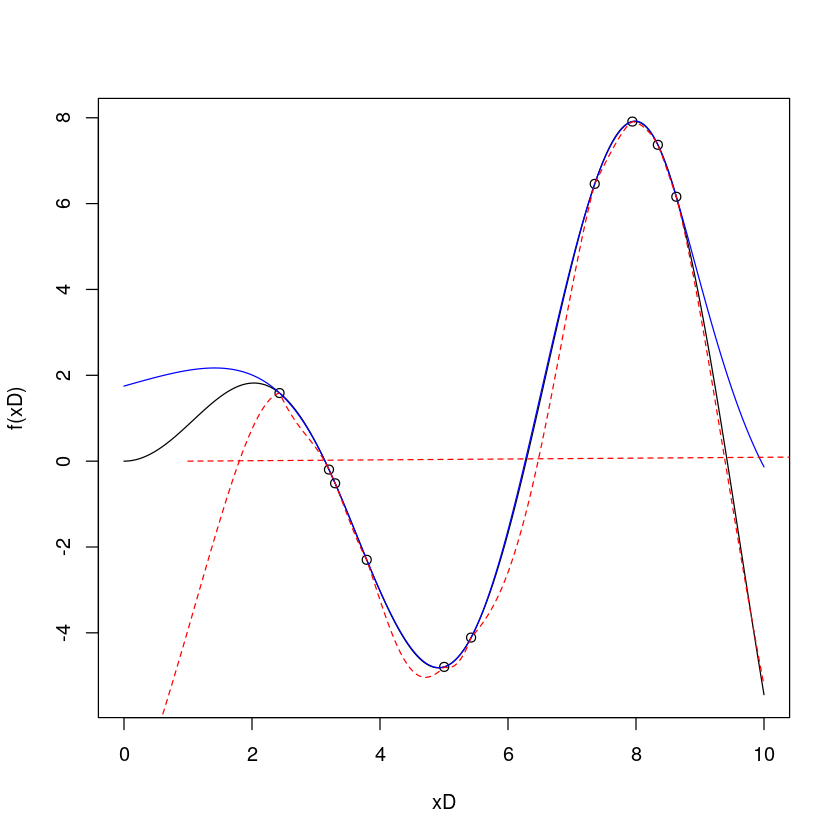

In [10]:
plot(xD,f(xD),type='l')
points(x,y)
lines(xD,fittedp$mean,col='blue')
lines(xD,fittedp$lower95,lty=2,col='red')
lines(xD,fittedp$upperr95,lty=2,col='red')

<a id="Illustration"></a>
## Multi-Fidelity in 1 dimension

### Forester Function

To illustrate the simple fidelity model we will use the well known Forester function to illustrate the AR(1) model.

In [43]:
f1L <- function(x){ # Low fidelity function
    return(1/2*f1H(x)+10*(x-0.5) +5)}

f1H <- function(x){ # high fidelity function
    return((6*x-2)^2*sin(12*x-4))}

We generate data to visualise the function

In [74]:
dimprob = 1
level = 2
dim = 1
xD = matrix(runif(400*dim,0,1),ncol=dim)#random uniform point in set set, fot the test part
xD = xD[order(xD)]
testdata = f1H(xD)
testdataL = f1L(xD)

Definition of a nested LHS plan of experiment

In [148]:
NL <- 170
NH <- 31
### The random version
#XL <- matrix(runif(NL*dimprob,0,1),ncol=dimprob)
#XH <- matrix(runif(NH*dimprob,0,1),ncol=dimprob)
#Dsg <- NestedDesignBuild(design = list(matrix(XL,ncol=dimprob),matrix(XH,ncol=dimprob)))

### The LHS version
XL <- lhsDesign(NL, dim)
XH <- lhsDesign(NH, dim)
Dsg <- NestedDesignBuild(design = list(XL$design,XH$design))

### Extraction of the plan
XL <- Dsg$PX
XH <- ExtractNestDesign(Dsg,2)
# realisation de la fonction
ZL <- f1L(XL)
ZH <- f1H(XH)


Regression

In [149]:
### The AR(1) model
formulaL = ~ 1	# low-fidelity trend
formulaH = ~ 1	# high-fidelity trend
cov.type = "matern5_2"	# covariance matern

# definition and optimization 
modelmulti <- MuFicokm(formula = list( formulaL, formulaH),MuFidesign = Dsg, response = list( ZL, ZH),nlevel = level, covtype=cov.type, estim.method="MLE", control=list( trace=FALSE))
# Prediction mean and variance
pred <- predict(object = modelmulti, xD, type = 'UK')

Export data

In [150]:
data = data.frame( XL = XL, ZL = ZL)
write.csv( data, "LowFiData.csv")
data = data.frame( XH = XH, ZH = ZH)
write.csv( data, "HighFiData.csv")
data = data.frame( xD = xD, testdata = testdata, pred = pred$mean, sig = pred$sig2)
write.csv( data, "TestData.csv")

Plot the realization

In [151]:
#help(MuFicokm)

In [152]:
mean <- pred$mean
std <- pred$sig2

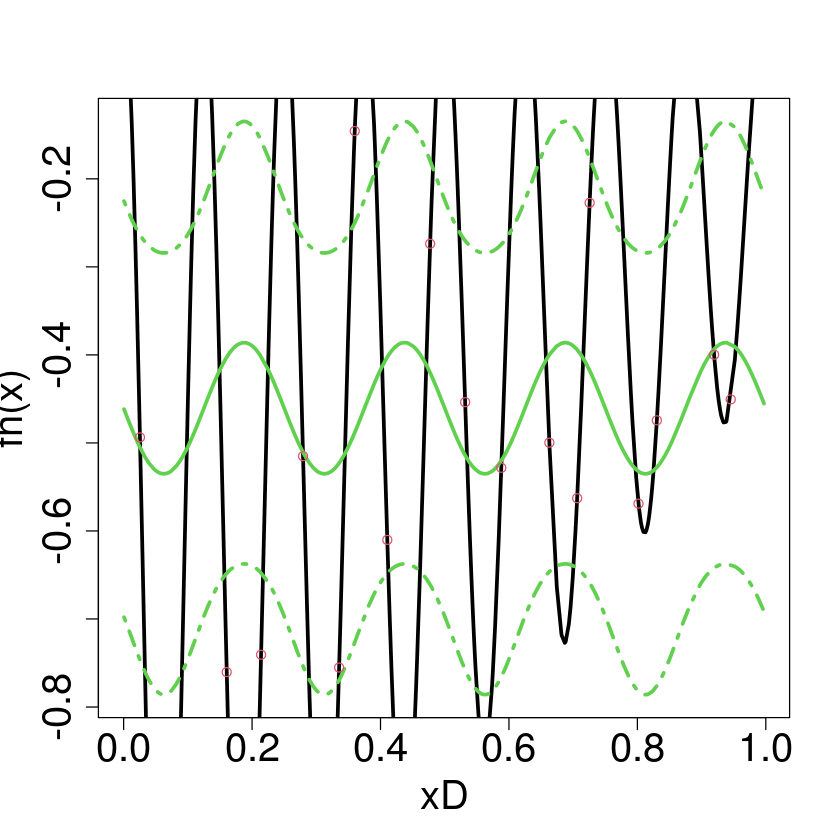

In [153]:
plot( xD, testdata, type='l', col=1, ylab="fh(x)", cex.axis=2, cex.lab =2, lwd = 3, ylim = c(min(mean - 1.96*std), max(mean+1.96*std)))
lines( xD, mean, lwd = 3, col=3)
lines( xD, mean + 1.96*std, lwd = 3, col=3, lty=4)
lines( xD, mean - 1.96*std, lwd = 3, col=3, lty=4)
points( XH, ZH, col=2)

For crossvalidation

In [154]:
pred <- predict( modelmulti, XH,  'UK')$mean + apply(matrix(1:NH),1,function(x)CrossValidationMuFicokmAll(modelmulti,x)$CVerrall)

err <- 1 - sum((pred - ZH)^2)/(var(ZH)*NH)
print(err)

           [,1]
[1,] 0.05539704


<a id="Example"></a>
## Double pendulum, the illustration for large dimension

We import the function of the code givent in a simple example of the double pendulum:
<img src='./exampledata/pendulum.png'  alt="Roots" style="width: 350px;"/>
This problem can be express by the Newton's laws of motion. However there is no analytical solution consequently we use a integration method to have the high fidelity code. For the low fidelity code we have the consider that $\theta$ is small.

In [20]:
source('exampledata/donnees_pendule.R')

In the first case we consider that the code is only a function of one variable $y_0$. We consider the 

In [21]:
# the dimension of the problem is small
dimprob = 1
level = 2

f1L <- function(x){
    y=rep(0, dim(x)[1])
    for(i in 1:dim(x)[1]){
    sys = SysPendulePlaqueLin(M=5*x[i,2]+3,k=0.1+x[i,3]*2,theta0=x[i,5]*pi/4+pi/4,Dtheta0=x[i,4]/6,Temps=t,y0=x[i,1])
    y[i]=max(sys[1,])
    }
    return(y)}

f1H <- function(x){
    y=rep(0, dim(x)[1])
    for(i in 1:dim(x)[1]){
    sys = SysPendulePlaque(M=5*x[i,2]+3,k=0.1+x[i,3]*2,theta0=x[i,5]*pi/4+pi/4,Dtheta0=x[i,4]/6,Temps=t,y0=x[i,1])
    y[i]=max(sys[,1])
    }
    return(y)}

In [22]:
dim = 5
Ntest = 400
xD = matrix(runif(Ntest*dim,0,1),ncol=dim)#random uniform point in set set, fot the test part
#xD = xD[order(xD)]
testdata = f1H(xD)
testdataL = f1L(xD)

Definition of an nested lhs plan of experiment

In [23]:
NL <- 100
NH <- 30
#XL <- matrix(runif(NL*dimprob,0,1),ncol=dimprob)
#XH <- matrix(runif(NH*dimprob,0,1),ncol=dimprob)
XL <- lhsDesign(NL, dim)
XH <- lhsDesign(NH, dim)
#Dsg <- NestedDesignBuild(design = list(matrix(XL,ncol=dimprob),matrix(XH,ncol=dimprob)))
Dsg <- NestedDesignBuild(design = list(XL$design,XH$design))
XL <- Dsg$PX
XH <- ExtractNestDesign(Dsg,2)
# realisation de la fonction
ZL <- f1L(XL)
ZH <- f1H(XH)

<a id="AR1"></a>
### The AR(1) Model

In [24]:
formulaL = ~ 1
formulaH = ~ 1
cov.type = "matern5_2"

modelmulti <- MuFicokm(formula = list( formulaL, formulaH),MuFidesign = Dsg, response = list( ZL, ZH),nlevel = level, covtype=cov.type, estim.method="MLE", control=list( trace=FALSE))
# moyenne de prédiction
pred <- predict(object = modelmulti, xD, type = 'UK')

In [25]:
Q2 = 1- sum(( testdata - pred$mean)^2)/(var(testdata)*Ntest)
print(Q2)

[1] 0.9661057


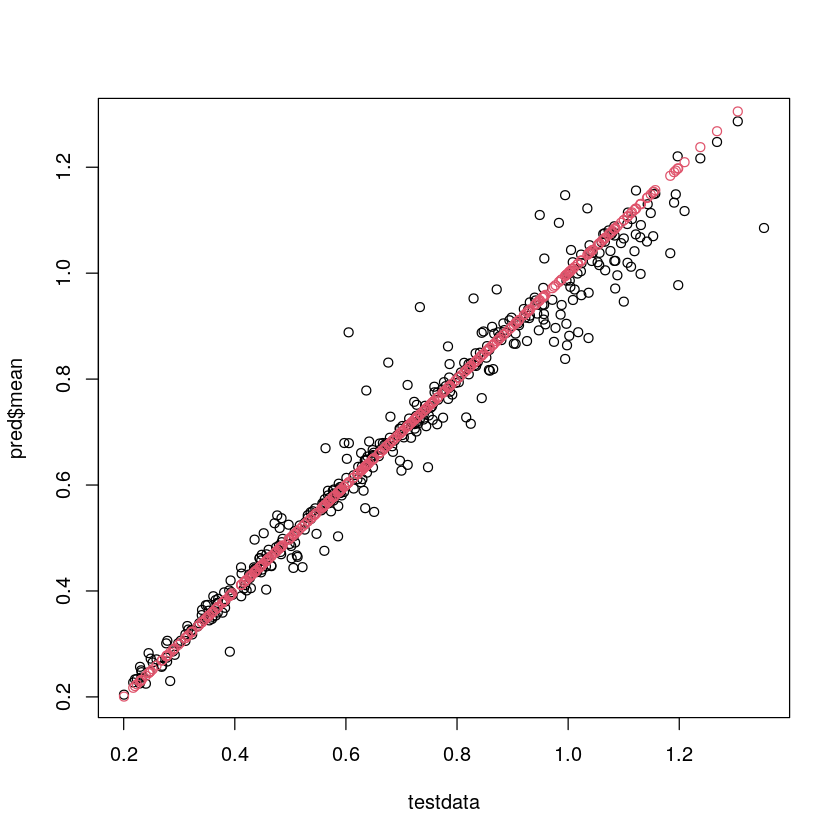

In [26]:
plot( testdata, pred$mean)
points( testdata, testdata, col=2)

### other functions

Linear-B

In [57]:
f1L <- function(x){ # Low fidelity function
    return(2*f1H(x)+(x^3-0.5)*sin(3*x-0.5)+4*cos(2*x))}

f1H <- function(x){ # high fidelity function
    return(5*x^2*sin(12*x))}

NonLinear- A

In [72]:
f1L <- function(x){ # Low fidelity function
    return(sin(8*pi*x))}

f1H <- function(x){ # high fidelity function
    return((x-sqrt(2))*f1L(x)^2)}